# Data Loading

In [1]:
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import regularizers, optimizers
import os

from sklearn.model_selection import train_test_split

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron 

In [2]:
file_dir = "/Users/sakshisuman12/Desktop/MATH7243_project/unzipped/XN_project/renders_small/"

training_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    file_dir, image_size=(512, 512), batch_size=64, validation_split=0.2,
    subset="training", seed=123, label_mode="binary",
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    file_dir, image_size=(512, 512), batch_size=64, validation_split=0.2,
    subset="validation", seed=123, label_mode="binary",
)

class_names = training_dataset.class_names
print(type(training_dataset))
training_dataset

Found 12394 files belonging to 2 classes.
Using 9916 files for training.
Metal device set to: Apple M1 Max
Found 12394 files belonging to 2 classes.
Using 2478 files for validation.
<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>


2022-04-07 02:03:55.702513: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-07 02:03:55.702686: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


<BatchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

In [3]:
validation_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

In [4]:
for image, label in training_dataset.take(1):
    print(image.shape)
    print(label.shape)

2022-04-07 02:03:55.862762: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


(64, 512, 512, 3)
(64, 1)


In [5]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [6]:
class_weight = {0: 1/10000, 1: 1/1600}

In [7]:
batch_size = 64
print(training_dataset)
training_dataset = training_dataset.map(preprocess)
print(training_dataset)

<BatchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>
<MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>


In [8]:
training_dataset
training_dataset.map

<bound method DatasetV2.map of <MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>>

In [14]:
n_classes = len(class_names)

n_classes = 1 if n_classes == 2 else n_classes

In [15]:
base_model = tf.keras.applications.xception.Xception(weights="imagenet", include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(n_classes, activation="sigmoid")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_2[0][0]']                
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 ation)                         32)                                                         

                                                                                                  
 block4_sepconv1 (SeparableConv  (None, None, None,   188672     ['block4_sepconv1_act[0][0]']    
 2D)                            728)                                                              
                                                                                                  
 block4_sepconv1_bn (BatchNorma  (None, None, None,   2912       ['block4_sepconv1[0][0]']        
 lization)                      728)                                                              
                                                                                                  
 block4_sepconv2_act (Activatio  (None, None, None,   0          ['block4_sepconv1_bn[0][0]']     
 n)                             728)                                                              
                                                                                                  
 block4_se

 lization)                      728)                                                              
                                                                                                  
 add_16 (Add)                   (None, None, None,   0           ['block6_sepconv3_bn[0][0]',     
                                728)                              'add_15[0][0]']                 
                                                                                                  
 block7_sepconv1_act (Activatio  (None, None, None,   0          ['add_16[0][0]']                 
 n)                             728)                                                              
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, None, None,   536536     ['block7_sepconv1_act[0][0]']    
 2D)                            728)                                                              
          

 block9_sepconv3_act (Activatio  (None, None, None,   0          ['block9_sepconv2_bn[0][0]']     
 n)                             728)                                                              
                                                                                                  
 block9_sepconv3 (SeparableConv  (None, None, None,   536536     ['block9_sepconv3_act[0][0]']    
 2D)                            728)                                                              
                                                                                                  
 block9_sepconv3_bn (BatchNorma  (None, None, None,   2912       ['block9_sepconv3[0][0]']        
 lization)                      728)                                                              
                                                                                                  
 add_19 (Add)                   (None, None, None,   0           ['block9_sepconv3_bn[0][0]',     
          

                                                                                                  
 block12_sepconv2 (SeparableCon  (None, None, None,   536536     ['block12_sepconv2_act[0][0]']   
 v2D)                           728)                                                              
                                                                                                  
 block12_sepconv2_bn (BatchNorm  (None, None, None,   2912       ['block12_sepconv2[0][0]']       
 alization)                     728)                                                              
                                                                                                  
 block12_sepconv3_act (Activati  (None, None, None,   0          ['block12_sepconv2_bn[0][0]']    
 on)                            728)                                                              
                                                                                                  
 block12_s

In [10]:
for layer in base_model.layers:
    layer.trainable = False

In [11]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=[tf.keras.metrics.AUC(),
                                                                        tf.keras.metrics.FalsePositives(),
                                                                        tf.keras.metrics.FalseNegatives(),
                                                                        tf.keras.metrics.Precision(),
                                                                        tf.keras.metrics.Recall()])
history = model.fit(training_dataset, epochs=5, validation_data=validation_dataset, class_weight=class_weight)

Epoch 1/5


2022-04-07 02:04:05.155177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


155/155 [==============================] - ETA: 0s - loss: 2.9521e-04 - auc: 0.7377 - false_positives: 2716.0000 - false_negatives: 433.0000 - precision: 0.2518 - recall: 0.6785

2022-04-07 02:04:42.482757: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


155/155 [==============================] - 84s 533ms/step - loss: 2.9521e-04 - auc: 0.7377 - false_positives: 2716.0000 - false_negatives: 433.0000 - precision: 0.2518 - recall: 0.6785 - val_loss: 14.8636 - val_auc: 0.4972 - val_false_positives: 2.0000 - val_false_negatives: 347.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
155/155 [==============================] - 88s 564ms/step - loss: 1.5630e-04 - auc: 0.8376 - false_positives: 2039.0000 - false_negatives: 309.0000 - precision: 0.3373 - recall: 0.7706 - val_loss: 21.9800 - val_auc: 0.4946 - val_false_positives: 13.0000 - val_false_negatives: 347.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/5
155/155 [==============================] - 89s 570ms/step - loss: 1.6199e-04 - auc: 0.8436 - false_positives: 2037.0000 - false_negatives: 314.0000 - precision: 0.3365 - recall: 0.7669 - val_loss: 27.7048 - val_auc: 0.4960 - val_false_positives: 14.0000 - val_false_negatives: 347.0000 - val_precision: 

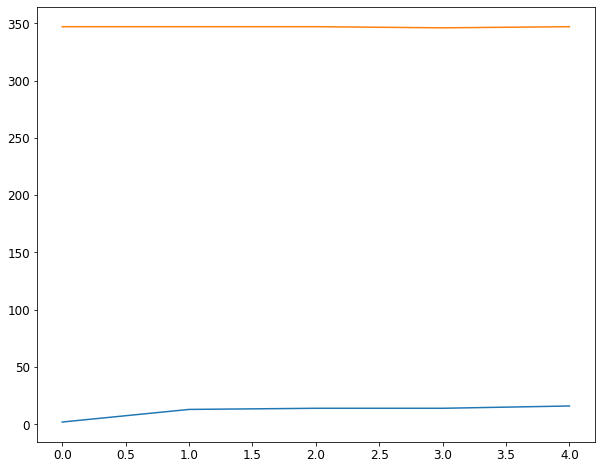

In [13]:
plt.figure(figsize=(10, 8))
plt.plot(history.history['val_false_positives'])
plt.plot(history.history['val_false_negatives'])
plt.show()